In [1]:
# Initial imports
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import time
#import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

from collections import Counter
from imblearn.combine import SMOTEENN
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
# Create DataFrame from CSV
t0 = time.time()
filtered_lyric_TF_df = pd.read_csv('../../Data/filtered_lyric_TF.csv')
filtered_lyric_TF_df = filtered_lyric_TF_df.drop([0,1])
filtered_lyric_TF_df.index = filtered_lyric_TF_df.index - 2
t1 = time.time()
print(f'Run time: {t1-t0} seconds')
filtered_lyric_TF_df.head()

Run time: 42.406694173812866 seconds


,song_name,artist_name,category_name,category_id,genre_list,audio_ft_danceability,audio_ft_energy,audio_ft_key,audio_ft_mode,audio_ft_speechiness,...,entirely,basket,car,shawn,nothingness,amused,corners,interlude,sting,axis
0,willow,Taylor Swift,pop,8.0,"['dance', 'pop']",0.392,0.574,7.0,1.0,0.1700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Stay Next To Me (with Chelsea Cutler),Quinn XCII,pop,8.0,"['indie', 'pop', 'electropop']",0.581,0.584,2.0,1.0,0.2840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,WITHOUT YOU,The Kid LAROI,pop,8.0,['australian'],0.662,0.413,0.0,1.0,0.0299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Heat Waves,Glass Animals,pop,8.0,"['shiver', 'indietronica', 'gauze']",0.761,0.525,11.0,1.0,0.0944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,r u ok,Tate McRae,pop,8.0,"['dance', 'pop', 'electropop', 'post-teen']",0.666,0.593,2.0,1.0,0.0373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Create a dictionary of category names and ids
cat_name_id = {}
category_list = ['blues', 'classical', 'country', 'funk', 'hiphop', 'indie_alt', 'jazz', 
                 'metal', 'pop', 'punk', 'rnb', 'rock', 'romance', 'soul']
for cat in category_list:
    cat_id = list(filtered_lyric_TF_df[filtered_lyric_TF_df['category_name']==cat]['category_id'])[0]
    cat_name_id[cat] = cat_id
    print(cat, cat_id)

blues 0.0
classical 1.0
country 2.0
funk 3.0
hiphop 4.0
indie_alt 5.0
jazz 6.0
metal 7.0
pop 8.0
punk 9.0
rnb 10.0
rock 11.0
romance 12.0
soul 13.0


In [4]:
# Create a genre lists column
t0 = time.time()
genre_lists = []
for index, row in filtered_lyric_TF_df.iterrows():
    genres = row['genre_list'].replace('[', '').replace(']', '').replace("'", '').split(', ')
    genre_lists.append(genres)
t1 = time.time()
print(f'Run time: {t1-t0} seconds')
len(genre_lists)

Run time: 48.433539152145386 seconds


8014

In [5]:
# Replace the genre_list column
filtered_lyric_TF_df['genre_list'] = genre_lists

In [6]:
# Find indeces to keep and indeces to remove
t0 = time.time()
cat_genre_dict = {'pop': ['pop'], 
                  'hiphop': ['rap', 'hip', 'trap'],
                  'metal': ['metal'], 
                  'rock': ['classic'], 
                  'jazz': ['jazz'], 
                  'rnb': ['r&b'], 
                  'romance': ['soft'], 
                  'soul': ['soul'], 
                  'indie_alt': ['indie', 'alternative'],
                  'classical': ['classical', 'operatic', 'dance'], 
                  'blues': ['modern', 'blues'],
                  'funk': ['funk', 'disco'], 
                  'punk': ['punk'],
                  'country': ['country']} 
indeces_to_keep = []
indeces_to_remove = []
for index, row in filtered_lyric_TF_df.iterrows():
    keep = False
    category = row['category_name']
    for genre in cat_genre_dict[category]:
        if genre in row['genre_list']:
            keep = True
            break
    if keep == True:
        indeces_to_keep.append(index)
    else:
        indeces_to_remove.append(index)
t1 = time.time()
print(f'Run time: {t1-t0} seconds')
print(len(indeces_to_keep))
len(indeces_to_remove)

Run time: 47.902966022491455 seconds
3975


4039

In [7]:
# Create non destructive copy and remove the unnecessary indeces
t0 = time.time()
filtered_lyric_TF_df2 = filtered_lyric_TF_df.drop(indeces_to_remove)
t1 = time.time()
print(f'Run time: {t1-t0} seconds')
print(len(filtered_lyric_TF_df2))
filtered_lyric_TF_df2.head()

Run time: 0.34555578231811523 seconds
3975


,song_name,artist_name,category_name,category_id,genre_list,audio_ft_danceability,audio_ft_energy,audio_ft_key,audio_ft_mode,audio_ft_speechiness,...,entirely,basket,car,shawn,nothingness,amused,corners,interlude,sting,axis
0,willow,Taylor Swift,pop,8.0,"[dance, pop]",0.392,0.574,7.0,1.0,0.1700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Stay Next To Me (with Chelsea Cutler),Quinn XCII,pop,8.0,"[indie, pop, electropop]",0.581,0.584,2.0,1.0,0.2840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,r u ok,Tate McRae,pop,8.0,"[dance, pop, electropop, post-teen]",0.666,0.593,2.0,1.0,0.0373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,BOYSHIT,Madison Beer,pop,8.0,"[dance, pop, electropop, post-teen]",0.638,0.699,1.0,1.0,0.0892,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Safe With Me (with Audrey Mika),Gryffin,pop,8.0,"[dance, pop, tropical, edm]",0.497,0.757,11.0,1.0,0.1270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Remove the romance and punk categories
filtered_lyric_TF_df2 = filtered_lyric_TF_df2[filtered_lyric_TF_df2['category_name']!='romance']
filtered_lyric_TF_df2 = filtered_lyric_TF_df2[filtered_lyric_TF_df2['category_name']!='punk']
len(filtered_lyric_TF_df2)

3759

In [9]:
# Define the features set
X = filtered_lyric_TF_df2.copy()
X = X.drop(['song_name', 'artist_name', 'category_name', 'category_id', 'genre_list'], axis=1)
X.head()

,audio_ft_danceability,audio_ft_energy,audio_ft_key,audio_ft_mode,audio_ft_speechiness,audio_ft_acousticness,audio_ft_instrumentalness,audio_ft_liveness,audio_ft_valence,audio_ft_tempo,...,entirely,basket,car,shawn,nothingness,amused,corners,interlude,sting,axis
0,0.392,0.574,7.0,1.0,0.1700,0.8330,0.00179,0.1450,0.529,81.112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.581,0.584,2.0,1.0,0.2840,0.0805,0.00000,0.3660,0.756,179.954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.666,0.593,2.0,1.0,0.0373,0.3180,0.00000,0.4140,0.329,140.013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.638,0.699,1.0,1.0,0.0892,0.0203,0.00000,0.0879,0.570,121.122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.497,0.757,11.0,1.0,0.1270,0.0449,0.00000,0.1190,0.507,169.902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Define the target set
y = filtered_lyric_TF_df2['category_id'].ravel()
y[:5]

array([8., 8., 8., 8., 8.])

In [49]:
# Perform combination sampling on the data
t0 = time.time()
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
t1 = time.time()
print(f'Run time: {t1-t0} seconds')

Run time: 79.40505313873291 seconds


In [50]:
# Count the resampled classes
Counter(y_resampled)

Counter({0.0: 103,
         1.0: 195,
         2.0: 8,
         3.0: 79,
         4.0: 73,
         5.0: 80,
         6.0: 70,
         7.0: 63,
         8.0: 79,
         10.0: 109,
         11.0: 75,
         13.0: 104})

In [128]:
# Get inertia values for different K values
inertia = []
k = list(range(12, 20))
for i in k:
    t0 = time.time()
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X_resampled)
    t1 = time.time()
    print(f'Run time to fit model with {i} clusters: {t1-t0} seconds')
    inertia.append(km.inertia_)

Run time to fit model with 12 clusters: 7.527256011962891 seconds
Run time to fit model with 13 clusters: 6.626453876495361 seconds
Run time to fit model with 14 clusters: 7.687489032745361 seconds
Run time to fit model with 15 clusters: 7.379516124725342 seconds
Run time to fit model with 16 clusters: 8.2744460105896 seconds
Run time to fit model with 17 clusters: 7.41452431678772 seconds
Run time to fit model with 18 clusters: 7.289008140563965 seconds
Run time to fit model with 19 clusters: 7.6561431884765625 seconds


<AxesSubplot:title={'center':'Elbow Curve'}, xlabel='k', ylabel='inertia'>

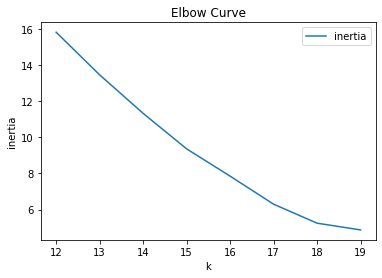

In [129]:
# Define a DataFrame to plot the Elbow Curve
elbow_data = {'k': k, 'inertia': [i/(10**10) for i in inertia]}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.plot.line(x='k', y='inertia', title='Elbow Curve', xlabel='k', ylabel='inertia')

In [130]:
# Draw conclusions about the Elbow Curve
differences = []
for i in range(len(df_elbow)-1):
    differences.append(df_elbow['inertia'][i]-df_elbow['inertia'][i+1])

differences2 = []
for i in range(len(differences)-1):
    differences2.append(differences[i]-differences[i+1])

for index, diff in enumerate(differences2):
    if diff == max(differences2):
        print(f'The optimal number of clusters is {index+13}.')

The optimal number of clusters is 18.


In [108]:
# Add new k-means column to filtered_lyric_TF_df2
model = KMeans(n_clusters=12, random_state=5)
t0 = time.time()
model.fit(X)
t1 = time.time()
print(f'Run time: {t1-t0} seconds')
filtered_lyric_TF_df2['k-means'] = model.predict(X)

model = KMeans(n_clusters=12, random_state=5)
t0 = time.time()
model.fit(X_scaled)
t1 = time.time()
print(f'Run time: {t1-t0} seconds')
filtered_lyric_TF_df2['k-means_scaled'] = model.predict(X_scaled)

model = KMeans(n_clusters=15, random_state=5)
t0 = time.time()
model.fit(X_resampled)
t1 = time.time()
print(f'Run time: {t1-t0} seconds')
filtered_lyric_TF_df2['k-means_resampled'] = model.predict(X)

filtered_lyric_TF_df2.head(3)

Run time: 26.429324865341187 seconds
Run time: 20.004209280014038 seconds
Run time: 7.587514162063599 seconds


,song_name,artist_name,category_name,category_id,genre_list,audio_ft_danceability,audio_ft_energy,audio_ft_key,audio_ft_mode,audio_ft_speechiness,...,shawn,nothingness,amused,corners,interlude,sting,axis,k-means,k-means_scaled,k-means_resampled
0,willow,Taylor Swift,pop,8.0,"[dance, pop]",0.392,0.574,7.0,1.0,0.1700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10,4
1,Stay Next To Me (with Chelsea Cutler),Quinn XCII,pop,8.0,"[indie, pop, electropop]",0.581,0.584,2.0,1.0,0.2840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10,4
4,r u ok,Tate McRae,pop,8.0,"[dance, pop, electropop, post-teen]",0.666,0.593,2.0,1.0,0.0373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,10,12


In [125]:
# Create tuples of categories and k-means predictions
t0 = time.time()
category_preds = []
category_preds_resampled = []
for index, row in filtered_lyric_TF_df2.iterrows():
    category_preds.append((row['category_id'], row['k-means']))
    category_preds_resampled.append((row['category_id'], row['k-means_resampled']))
t1 = time.time()
print(f'Run time: {t1-t0} seconds')
print(category_preds[0:5])
print(category_preds_resampled[0:5])

Run time: 21.520725965499878 seconds
[(8.0, 0), (8.0, 0), (8.0, 10), (8.0, 3), (8.0, 0)]
[(8.0, 10), (8.0, 10), (8.0, 10), (8.0, 10), (8.0, 10)]
[(8.0, 4), (8.0, 4), (8.0, 12), (8.0, 0), (8.0, 4)]


In [132]:
# Find the most popular predictions for each category
category_predictions = {}
category_list = list(set(filtered_lyric_TF_df2['category_id']))
for category in category_list:
    predictions = []
    for pair in category_preds:
        if pair[0] == category:
            predictions.append(pair[1])
    unique_preds = list(set(predictions))
    prediction_counts = []
    for prediction in unique_preds:
        prediction_counts.append((prediction, predictions.count(prediction)))
    category_predictions[category] = sorted(prediction_counts, key = lambda x: x[1], reverse=True)#[0:3]
    print(category, category_predictions[category])

0.0 [(10, 59), (3, 53), (0, 42), (8, 42), (5, 32), (1, 29), (4, 22), (9, 18), (11, 10), (2, 8)]
1.0 [(5, 9), (8, 6), (7, 4), (11, 3), (0, 2), (4, 2), (1, 1), (3, 1), (6, 1), (9, 1), (10, 1)]
2.0 [(10, 274), (0, 246), (3, 181), (8, 129), (5, 69), (9, 37), (1, 34), (4, 6), (11, 1)]
3.0 [(1, 25), (5, 24), (8, 21), (0, 20), (4, 20), (11, 14), (10, 12), (3, 11), (2, 9), (9, 6), (7, 1)]
4.0 [(3, 79), (0, 66), (8, 63), (10, 58), (9, 57), (5, 48), (1, 47), (4, 24), (11, 3), (2, 1)]
5.0 [(0, 76), (8, 72), (10, 70), (5, 45), (1, 37), (3, 34), (4, 18), (9, 11), (11, 9), (2, 3)]
6.0 [(1, 13), (5, 12), (0, 9), (10, 9), (4, 8), (3, 7), (8, 6), (11, 6), (7, 3), (2, 2), (9, 2)]
7.0 [(1, 71), (5, 71), (8, 54), (4, 41), (0, 36), (11, 26), (10, 23), (3, 20), (2, 16), (9, 5), (7, 3)]
8.0 [(10, 89), (3, 82), (0, 79), (8, 55), (5, 19), (9, 11), (1, 6), (4, 2)]
10.0 [(5, 55), (8, 48), (0, 33), (1, 27), (10, 25), (3, 11), (4, 8), (9, 3), (11, 3)]
11.0 [(5, 60), (1, 35), (0, 30), (3, 25), (10, 24), (8, 19), (4

In [ ]:

blues 0.0     - 11 (10) 
classical 1.0 - 6  (1)
country 2.0   - 10 (274)   
funk 3.0      - 2  (9) 
hiphop 4.0    - 9  (57) 
indie_alt 5.0 - 0  (76)
jazz 6.0      - 7  (3)
metal 7.0     - 1  (71)
pop 8.0       - 3  (82) 
rnb 10.0      - 8  (48)
rock 11.0     - 5  (60) 
soul 13.0     - 4  (11) 


In [135]:
# Print the accuracy percentage
total = 184 + 716 + 534 + 54 + 616 + 373 + 1 + 12 + 486 + 697 + 95 + 166
correct = 10 + 1 + 274 + 9 + 57 + 76 + 3 + 71 + 82 + 48 + 60 + 11
print(f'{correct} correct predictions out of {total}')
print(f'Accuracy: {correct/total}')

702 correct predictions out of 3934
Accuracy: 0.1784443314692425


In [131]:
# Find the most popular resampled predictions for each category 
category_predictions = {}
category_list = list(set(filtered_lyric_TF_df2['category_id']))
for category in category_list:
    predictions = []
    for pair in category_preds_resampled:
        if pair[0] == category:
            predictions.append(pair[1])
    unique_preds = list(set(predictions))
    prediction_counts = []
    for prediction in unique_preds:
        prediction_counts.append((prediction, predictions.count(prediction)))
    category_predictions[category] = sorted(prediction_counts, key = lambda x: x[1], reverse=True)#[0:3]
    print(category, category_predictions[category])

0.0 [(12, 88), (4, 52), (11, 39), (10, 37), (6, 28), (0, 26), (2, 24), (5, 13), (14, 8)]
1.0 [(2, 6), (11, 6), (6, 4), (5, 3), (10, 3), (1, 2), (4, 2), (7, 2), (0, 1), (9, 1), (12, 1)]
2.0 [(4, 350), (12, 289), (11, 133), (0, 73), (6, 71), (2, 36), (10, 24), (5, 1)]
3.0 [(10, 31), (2, 25), (4, 24), (11, 18), (5, 16), (6, 16), (12, 15), (14, 9), (0, 8), (7, 1)]
4.0 [(12, 91), (4, 81), (0, 80), (11, 59), (10, 46), (2, 45), (6, 36), (5, 7), (14, 1)]
5.0 [(4, 113), (11, 60), (12, 58), (6, 43), (10, 41), (2, 31), (0, 17), (5, 9), (14, 3)]
6.0 [(10, 15), (4, 13), (2, 9), (6, 9), (12, 9), (11, 7), (5, 6), (0, 4), (7, 2), (14, 2), (1, 1)]
7.0 [(10, 82), (2, 57), (6, 52), (4, 48), (11, 45), (5, 31), (12, 24), (14, 16), (0, 8), (7, 3)]
8.0 [(4, 117), (12, 106), (11, 53), (0, 32), (6, 21), (2, 9), (10, 5)]
10.0 [(4, 47), (6, 42), (11, 41), (2, 34), (10, 24), (12, 17), (0, 5), (5, 3)]
11.0 [(2, 44), (12, 37), (4, 35), (6, 33), (10, 33), (11, 20), (0, 18), (5, 14), (14, 10), (7, 1)]
13.0 [(12, 56),

In [ ]:

blues 0.0     - 5  (13)
classical 1.0 - 9  (1)
country 2.0   - 4  (350)   
funk 3.0      - 7  (1)
hiphop 4.0    - 12 (91)
indie_alt 5.0 - 11 (60)
jazz 6.0      - 1  (1)
metal 7.0     - 10 (82)
pop 8.0       - 0  (0)
rnb 10.0      - 6  (42)
rock 11.0     - 2  (44)
soul 13.0     - 14 (4)


In [85]:
# Print the accuracy percentage
total = 184 + 716 + 534 + 54 + 616 + 373 + 1 + 12 + 486 + 697 + 95 + 166
correct = 13 + 1 + 350 + 1 + 91 + 60 + 1 + 82 + 42 + 44 + 4
print(f'{correct} correct predictions out of {total}')
print(f'Accuracy: {correct/total}')

689 correct predictions out of 3934
Accuracy: 0.17513980681240468


In [32]:
# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6010, 12020)
(2004, 12020)
(6010,)
(2004,)
